In [1]:
# Goal: estimate the iPTF13bvn oxygen mass in the late-time nebular spectrum
import sys, os
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds

In [21]:
sds = specds.load_dataset('SN2008D')

In [33]:
spec_n = sds.names[-1]
spec = sds[spec_n]
spec = spec[~np.isnan(spec['flux'])]
#spec['restwave'] += 40
#spec['obswave'] += 40
spec.meta

OrderedDict([('time', 54624.0),
             ('phase', 131.0),
             ('filename', 'sn2008d-20080607.259-br+error.flm'),
             ('file_name', 'sn2008d-20080607.259-br+error.flm'),
             ('obs_mjd', 54624.0),
             ('name', 'sn2008d-20080607')])

In [30]:


spec

<Table length=3063>
obswave      restwave               flux          mask
float64      float64              float64         bool
------- ------------------ ---------------------- ----
 3140.0 3120.0107303599634 -5.263487659710402e-16 True
 3142.0   3121.99783405697 -6.498419314074216e-15 True
 3144.0 3123.9849377539763  3.126272941752121e-15 True
 3146.0  3125.972041450983  4.435033994482791e-16 True
 3148.0  3127.959145147989 1.8830144386214312e-16 True
 3150.0  3129.946248844996  4.371646134440935e-16 True
 3152.0  3131.933352542002 3.9007066559821953e-16 True
 3154.0 3133.9204562390087 -8.920563656560751e-16 True
 3156.0  3135.907559936015 -5.179816471336168e-16 True
 3158.0 3137.8946636330215  2.444500025228124e-15 True
    ...                ...                    ...  ...
 9250.0  9190.612524714601 3.5422090827809924e-17 True
 9252.0  9192.599628411608  3.800694083429871e-17 True
 9254.0  9194.586732108613 4.7140165047295713e-17 True
 9256.0   9196.57383580562 4.4218127051473767e-17 True
 9258.0  9198.560939502628  4.591613723099243e-17 True
 9260.0  9200.548043199633 3.5956347176451684e-17 True
 9262.0   9202.53514689664 5.3808102517164876e-17 True
 9264.0  9204.522250593645 4.6704959524823144e-17 True
 9266.0  9206.509354290652   5.09522642684919e-17 True
 9268.0   9208.49645798766 4.3244532636643816e-17 True

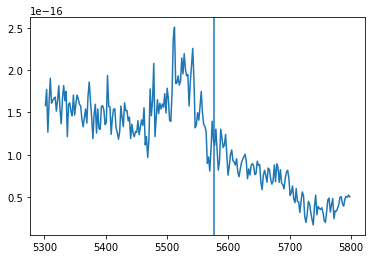

In [34]:
idx = np.logical_and(spec['restwave'] > 5300, spec['restwave'] < 5800)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
plt.axvline(5577)

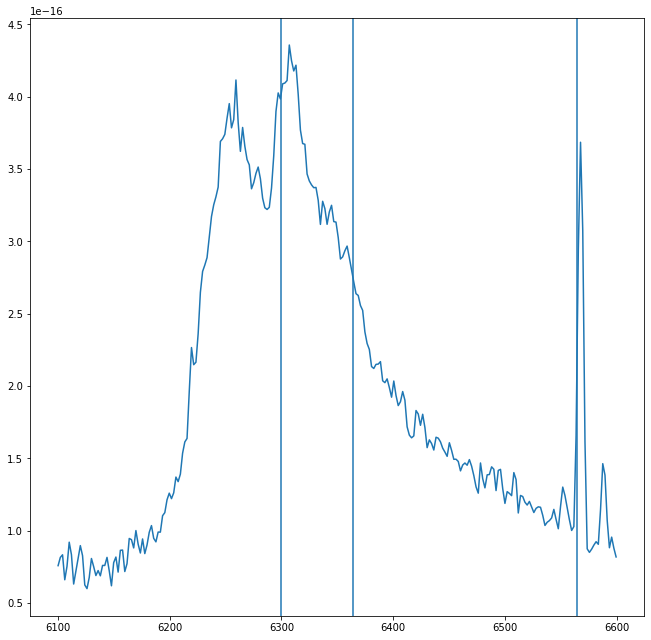

In [36]:
plt.figure(figsize=(11,11))

idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6600)
#idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6200)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
plt.axvline(6300)
plt.axvline(6364)
plt.axvline(6564)

In [7]:
cfg = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=27)

In [8]:
dist_mpc = 25.53
dist_mpc_err = 1.79
dist_min = (dist_mpc-dist_mpc_err) * u.pc.to(u.cm) * 1e6
dist_max = (dist_mpc+dist_mpc_err) * u.pc.to(u.cm) * 1e6
dist_range = (dist_min, dist_max)
#redshift2distance = utils.redshift2distance
results, samples = oxygen.run_dynesty_fit(cfg, dist_range=dist_range)

3704it [00:07, 484.19it/s, batch: 0 | bound: 1 | nc: 25 | ncall: 37160 | eff(%):  9.706 | loglstar:   -inf < -2122.185 <    inf | logz: -2130.973 +/-  0.123 | dlogz: 488.657 >  0.010]    


KeyboardInterrupt: 

In [ ]:
LABELS = ['M(OI)', 'T_LTE', 'W', 'C_5577', 'C_63xx', 'S_5577', 'S_63xx', 'D', 'Woffset', 'Tau', 'log f', 'BR5577', 'AmpE1', 'AmpE2', 'AmpE3', 'AmpE4']
_=dyplot.cornerplot(results, labels=LABELS, show_titles=True)

In [ ]:
plt.figure(figsize=(11,11))

idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6600)
#idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6200)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
#continuum_level_6300_6364 = 0.3e-17
#continuum_slope_6300_6364 = 0.03/1e18
#amplitude_6300 = 1.3e-15
#amplitude_6364 = 0.5e-15
#line_width = 16
#modflux = oxygen.generation_func_5577(spec['restwave'][idx], continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width)

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
new_samples = dyfunc.resample_equal(samples, weights)

plt.axvline(6300, color='orange')
plt.axvline(6364, color='orange')
plt.axvline(6158+7.3, color='orange')

extra_idx = cfg.extra_lines > 6000

#print(len(new_samples))
#print(cfg.extra_lines.dtype)
for i in range(300):
    p = new_samples[(i*38) % len(new_samples)]
    #oxygen_mass = np.exp(p[0])
    p = np.array(p, copy=True)
    #p[0] /= 1.3
    #oxygen_masses[i] = p[0]
    
    line_width = p[2]#*1.3
    wlen_offset = p[8]
    #line_skew = p[12]
    #p[9] -= 3

    continuum_level_5577 = p[3]/1e17
    continuum_level_6300_6364 = p[4]/1e17

    continuum_slope_5577 = p[5]/1e17
    continuum_slope_6300_6364 = p[6]/1e17
    
    extra_lines_amps = np.exp(p[12:])/1e17
    #extra_lines_amps = np.exp([6])/1e17
    #print(extra_lines_amps.dtype)

    fluxes = oxygen.create_fluxes(p)
    #fluxes = create_fluxes(p)
    
    amplitude_5577 = fluxes[0]
    amplitude_6300 = fluxes[1]
    amplitude_6364 = fluxes[2]
    
    #print(spec['restwave'][idx]+wlen_offset)
    modflux = np.empty(len(spec['restwave'][idx]))
    for j in range(len(modflux)):
        modflux[j] = oxygen.generation_func_6300_6364((spec['restwave'][idx]+wlen_offset)[j], continuum_level_6300_6364, continuum_slope_6300_6364, amplitude_6300, amplitude_6364, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    plt.plot(spec['restwave'][idx], modflux, alpha=0.01, color='grey')
plt.axvline(cfg.start6300_6364, color='blue', ls='--')
plt.axvline(cfg.stop6300_6364, color='blue', ls='--')

for l in cfg.extra_lines[extra_idx]:
    plt.axvline(l+7.3, color='cyan')

plt.axvline(6391+7.3, color='purple')
plt.axvline(6453+7.3, color='red')
plt.axvline(6454+7.3, color='red')
plt.axvline(6455+7.3, color='red')
#plt.axvline(6726, color='red')
#plt.axvline(, color='red')
    
plt.grid()

In [ ]:
idx = new_samples[:,0] < 2
plt.hist2d(new_samples[:,0][idx], new_samples[:,1][idx], bins=100);
plt.axvline(0.3)

In [ ]:
np.percentile(new_samples[:,0], 13)